## Import Library

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [13]:
df = pd.read_csv('../data/Fashion_Retail_Sales.csv')
df.head()

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
0,4018,Handbag,4619.0,2023-02-05,NaN,Credit Card
1,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card
2,4019,Tank Top,2102.0,2023-03-23,4.1,Cash
3,4097,Leggings,3126.0,2023-03-15,3.2,Cash
4,3997,Wallet,3003.0,2022-11-27,4.7,Cash


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Reference ID  3400 non-null   int64  
 1   Item Purchased         3400 non-null   object 
 2   Purchase Amount (USD)  2750 non-null   float64
 3   Date Purchase          3400 non-null   object 
 4   Review Rating          3076 non-null   float64
 5   Payment Method         3400 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 159.5+ KB


In [11]:
df.describe(include="all")

,Customer Reference ID,Item Purchased,Purchase Amount (USD),Date Purchase,Review Rating,Payment Method
count,3400.000000,3400,2750.000000,3400,3076.000000,3400
unique,NaN,50,NaN,365,NaN,2
top,NaN,Belt,NaN,2023-09-22,NaN,Credit Card
freq,NaN,90,NaN,17,NaN,1770
mean,4039.660588,NaN,156.709818,NaN,2.999057,NaN
std,48.122583,NaN,419.536669,NaN,1.156505,NaN
min,3957.000000,NaN,10.000000,NaN,1.000000,NaN
25%,3997.000000,NaN,57.000000,NaN,2.000000,NaN
50%,4040.000000,NaN,110.000000,NaN,3.000000,NaN
75%,4081.000000,NaN,155.750000,NaN,4.000000,NaN


## Cleaning Data

In [12]:
# Ganti missing value dengan polarisasi linear
df['Date Purchase'] = pd.to_datetime(df['Date Purchase'])
df = df.sort_values('Date Purchase')

# Interpolasi linear untuk missing value
df['Purchase Amount (USD)'] = df['Purchase Amount (USD)'].interpolate(method='linear')
df['Review Rating'] = df['Review Rating'].interpolate(method='linear')

df = df[df['Purchase Amount (USD)'].notna()]

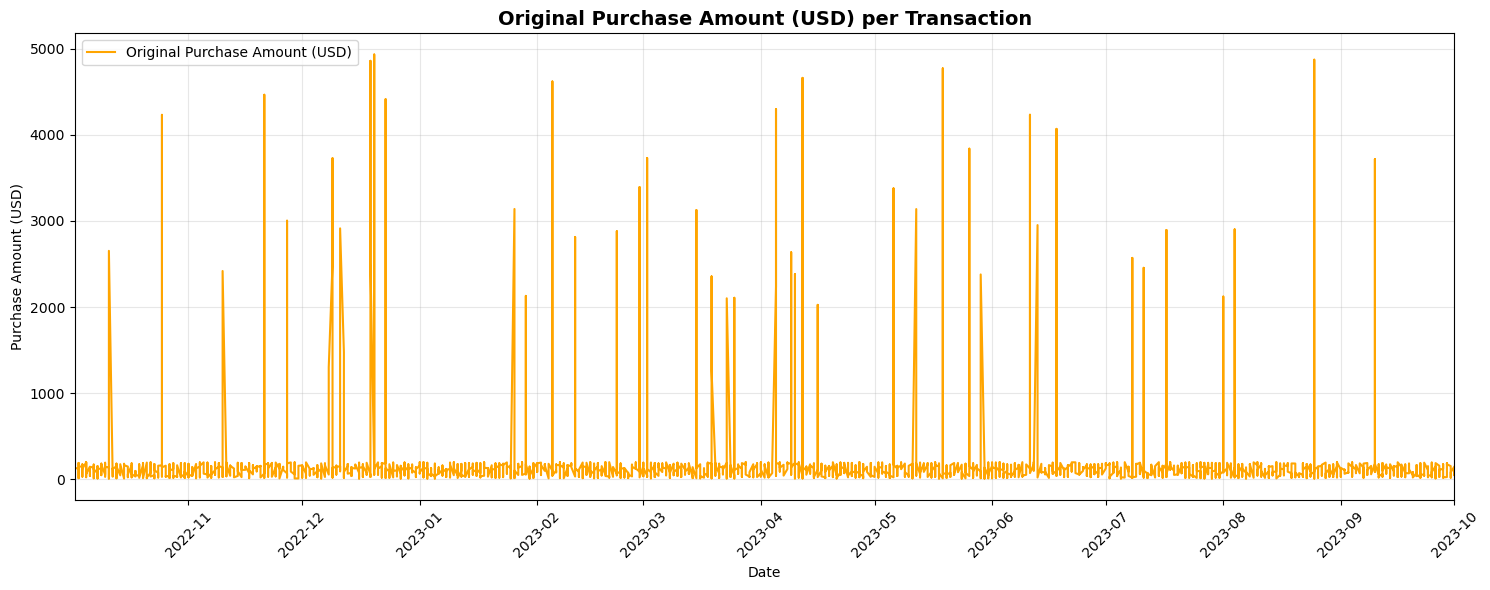

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df['Date Purchase'], df['Purchase Amount (USD)'], label='Original Purchase Amount (USD)', color='orange')
plt.title('Original Purchase Amount (USD) per Transaction', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Purchase Amount (USD)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(pd.Timestamp('2022-10-02'), pd.Timestamp('2023-10-01'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocessing  Data

In [14]:
# Set index dan resample harian
df_daily = df.set_index('Date Purchase').resample('D').agg({
    'Purchase Amount (USD)': 'sum',
    'Item Purchased': 'count',
    'Review Rating': 'mean'
}).fillna(0)

# Smoothing menggunakan rolling average
df_daily['Purchase Amount (USD)'] = df_daily['Purchase Amount (USD)'].rolling(window=7, center=True).mean().fillna(method='bfill').fillna(method='ffill')

# Ekstraksi fitur waktu
df_daily['day_of_week'] = df_daily.index.dayofweek
df_daily['month'] = df_daily.index.month
df_daily['quarter'] = df_daily.index.quarter
df_daily['is_weekend'] = df_daily['day_of_week'].isin([5,6]).astype(int)
df_daily['MA7'] = df_daily['Purchase Amount (USD)'].rolling(window=7).mean()
df_daily['MA30'] = df_daily['Purchase Amount (USD)'].rolling(window=30).mean()
df_daily = df_daily.fillna(method='bfill').fillna(method='ffill')

# Scaling fitur eksogen dan target
exog_columns = ['Item Purchased', 'Review Rating', 'day_of_week', 'month', 'quarter', 'is_weekend', 'MA7', 'MA30']
exog_scaler = MinMaxScaler()
df_daily[exog_columns] = exog_scaler.fit_transform(df_daily[exog_columns])

scaler = MinMaxScaler()
scaled_purchase = scaler.fit_transform(df_daily[['Purchase Amount (USD)']])
df_daily['Purchase Amount (USD)'] = scaled_purchase

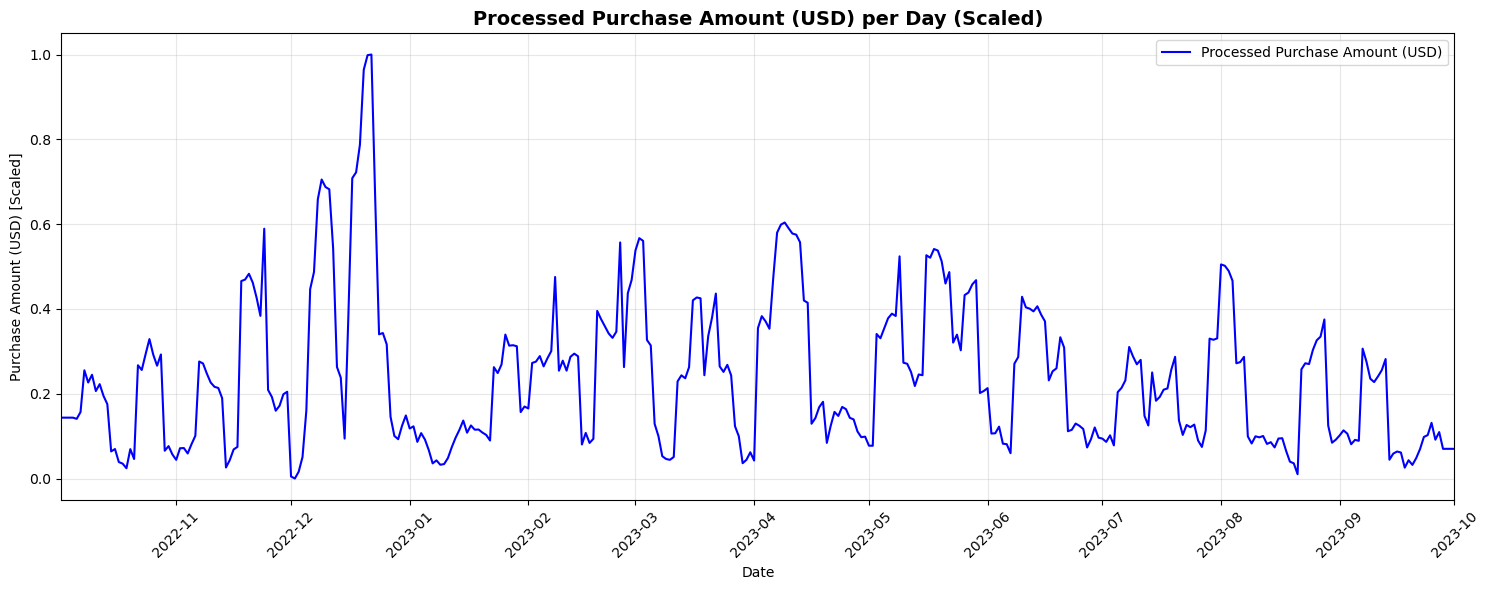

In [15]:
plt.figure(figsize=(15,6))
plt.plot(df_daily.index, df_daily['Purchase Amount (USD)'], label='Processed Purchase Amount (USD)', color='blue')
plt.title('Processed Purchase Amount (USD) per Day (Scaled)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Purchase Amount (USD) [Scaled]')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(pd.Timestamp('2022-10-02'), pd.Timestamp('2023-10-01'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Split Data (80:20)

In [16]:
n = len(df_daily)
train_size = int(n * 0.8)
test_size = n - train_size

train_data = df_daily.iloc[:train_size]
test_data = df_daily.iloc[train_size:]

train_exog = train_data[exog_columns]
test_exog = test_data[exog_columns]

# Modeling SARIMAX

In [17]:
print("Training Enhanced SARIMAX Model with Exogenous Variables...")
param_combinations = [
    ((1,1,1), (1,1,1,7)),
    ((2,1,2), (1,1,1,7)),
    ((1,1,2), (0,1,1,7)),
    ((2,0,2), (1,1,1,7)),
    ((1,1,1), (2,1,1,7)),
]
best_aic = float('inf')
best_sarimax_model = None
best_params = None

for order, seasonal_order in param_combinations:
    try:
        model = SARIMAX(
            train_data['Purchase Amount (USD)'],
            exog=train_exog,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
            trend='c'
        )
        result = model.fit(disp=False)
        if result.aic < best_aic:
            best_aic = result.aic
            best_sarimax_model = result
            best_params = (order, seasonal_order)
    except Exception as e:
        continue

if best_sarimax_model is None:
    print("Fallback SARIMAX used.")
    model = SARIMAX(
        train_data['Purchase Amount (USD)'],
        exog=train_exog,
        order=(1,1,1),
        seasonal_order=(1,1,1,7),
        trend='c'
    )
    best_sarimax_model = model.fit(disp=False)
    best_params = ((1,1,1), (1,1,1,7))

print(f"Best SARIMAX params: {best_params}, AIC: {best_sarimax_model.aic:.2f}")
print("SARIMAX exogenous variables:", exog_columns)

Training Enhanced SARIMAX Model with Exogenous Variables...
Best SARIMAX params: ((2, 0, 2), (1, 1, 1, 7)), AIC: -576.36
SARIMAX exogenous variables: ['Item Purchased', 'Review Rating', 'day_of_week', 'month', 'quarter', 'is_weekend', 'MA7', 'MA30']


In [18]:
forecast = best_sarimax_model.get_forecast(steps=len(test_data), exog=test_exog)
sarimax_pred = forecast.predicted_mean
sarimax_pred_lower = forecast.conf_int().iloc[:, 0]
sarimax_pred_upper = forecast.conf_int().iloc[:, 1]

# Inverse scaling
sarimax_pred = scaler.inverse_transform(sarimax_pred.values.reshape(-1,1)).flatten()
sarimax_pred_lower = scaler.inverse_transform(sarimax_pred_lower.values.reshape(-1,1)).flatten()
sarimax_pred_upper = scaler.inverse_transform(sarimax_pred_upper.values.reshape(-1,1)).flatten()
actual_test = scaler.inverse_transform(test_data['Purchase Amount (USD)'].values.reshape(-1,1)).flatten()

## Modeling GRU

In [19]:
gru_features = ['Purchase Amount (USD)'] + exog_columns
gru_data = df_daily[gru_features].values

# Sequence length untuk GRU
n_steps = 14
print(f"Using sequence length of {n_steps} for GRU")

# Create sequences
X, y = [], []
for i in range(n_steps, len(gru_data)):
    X.append(gru_data[i-n_steps:i])
    y.append(gru_data[i, 0])  # target adalah kolom pertama
X, y = np.array(X), np.array(y)

# Split 80/20
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"GRU training data: {X_train.shape}")
print(f"GRU testing data: {X_test.shape}")

Using sequence length of 14 for GRU
GRU training data: (280, 14, 9)
GRU testing data: (71, 14, 9)


In [20]:
print("\nBuilding GRU model...")
gru_model = Sequential([
    # Increase complexity and add regularization
    GRU(128, return_sequences=True, input_shape=(n_steps, X.shape[2])),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Change to linear for regression
])

# Use a lower learning rate
optimizer = Adam(learning_rate=0.0005)
gru_model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])  # Huber loss is more robust
gru_model.summary()

# Callback functions for GRU
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increase patience
    restore_best_weights=True,
    min_delta=0.00001,  # More sensitive
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # More aggressive LR reduction
    patience=15,
    min_lr=1e-7,
    verbose=1
)


Building GRU model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 14, 128)        │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 14, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,633 (397.00 KB)

 Trainable params: 101,633 (397.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
print("\nTraining GRU model...")
history = gru_model.fit(
    X_train, y_train,
    epochs=300,  # Increase epochs
    batch_size=32,  # Larger batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Training GRU model...
Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.0488 - mae: 0.2449 - val_loss: 0.0113 - val_mae: 0.1361 - learning_rate: 5.0000e-04
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0207 - mae: 0.1697 - val_loss: 0.0173 - val_mae: 0.1654 - learning_rate: 5.0000e-04
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0190 - mae: 0.1589 - val_loss: 0.0083 - val_mae: 0.1187 - learning_rate: 5.0000e-04
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0178 - mae: 0.1457 - val_loss: 0.0113 - val_mae: 0.1349 - learning_rate: 5.0000e-04
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0149 - mae: 0.1453 - val_loss: 0.0130 - val_mae: 0.1444 - learning_rate: 5.0000e-04
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0142 - mae: 0.1398 - val_loss: 0.0088 - val_mae: 0.1214 - learning_rate: 5.0000e-04
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0149 - mae: 0.1418 - val_loss: 0.0107 - val_mae: 0.1

In [22]:
y_pred_gru = gru_model.predict(X_test)
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


In [23]:
mae_sarimax = mean_absolute_error(actual_test, sarimax_pred)
mape_sarimax = mean_absolute_percentage_error(actual_test, sarimax_pred) * 100
r2_sarimax = r2_score(actual_test, sarimax_pred)
rmse_sarimax = np.sqrt(mean_squared_error(actual_test, sarimax_pred))

mae_gru = mean_absolute_error(y_test_inv, y_pred_gru_inv)
mape_gru = mean_absolute_percentage_error(y_test_inv, y_pred_gru_inv) * 100
r2_gru = r2_score(y_test_inv, y_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_gru_inv))

print("=== Enhanced SARIMAX Evaluation ===")
print(f"RMSE  : {rmse_sarimax:.2f}")
print(f"MAE   : {mae_sarimax:.2f}")
print(f"MAPE  : {mape_sarimax:.2f}%")
print(f"R2    : {r2_sarimax:.4f}")
print("\n=== Enhanced GRU Evaluation ===")
print(f"RMSE  : {rmse_gru:.2f}")
print(f"MAE   : {mae_gru:.2f}")
print(f"MAPE  : {mape_gru:.2f}%")
print(f"R2    : {r2_gru:.4f}")

=== Enhanced SARIMAX Evaluation ===
RMSE  : 345.28
MAE   : 271.05
MAPE  : 22.95%
R2    : 0.2638

=== Enhanced GRU Evaluation ===
RMSE  : 241.28
MAE   : 170.78
MAPE  : 14.35%
R2    : 0.6491


In [24]:
print("\nPredicting next 7 days with GRU...")
last_sequence = X_test[-1:]
future_predictions_gru = []

for _ in range(7):
    # Get prediction for next day
    next_pred = gru_model.predict(last_sequence)
    future_predictions_gru.append(next_pred[0, 0])

    # Update the sequence for next prediction
    new_seq = last_sequence[0][1:].copy()
    new_row = last_sequence[0][-1].copy()
    new_row[0] = next_pred[0, 0]  # Update only the target value
    last_sequence = np.append(new_seq, [new_row], axis=0).reshape(1, n_steps, X.shape[2])

# Inverse transform predictions
future_pred_inv_gru = scaler.inverse_transform(np.array(future_predictions_gru).reshape(-1, 1))

# Create future dates for GRU
future_dates_gru = pd.date_range(start=test_data.index[-1], periods=8)[1:]


Predicting next 7 days with GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [25]:
print("\nPredicting next 7 days with SARIMAX...")
# Persiapkan data untuk prediksi SARIMAX
last_date = test_data.index[-1]
future_dates_sarimax = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
future_exog = pd.DataFrame(index=future_dates_sarimax, columns=exog_columns)

# Copy pola dari minggu terakhir untuk exogenous features
for col in exog_columns:
    future_exog[col] = df_daily[col].iloc[-7:].values

# Prediksi SARIMAX
future_sarimax = best_sarimax_model.get_forecast(steps=7, exog=future_exog)
future_pred_sarimax = scaler.inverse_transform(future_sarimax.predicted_mean.values.reshape(-1,1)).flatten()


Predicting next 7 days with SARIMAX...


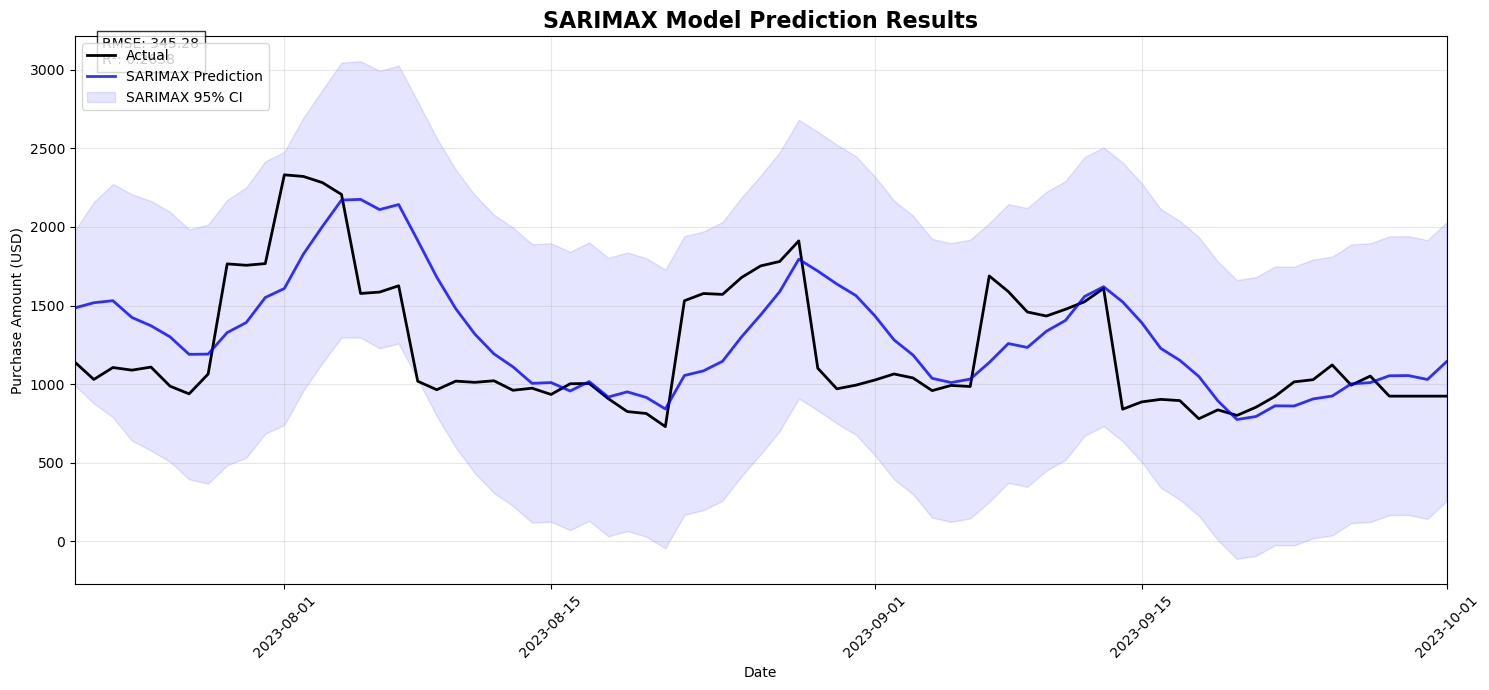

In [26]:
plt.figure(figsize=(15,7))
plt.plot(test_data.index, actual_test, label='Actual', linewidth=2, color='black')
plt.plot(test_data.index, sarimax_pred, label='SARIMAX Prediction', linewidth=2, color='blue', alpha=0.8)
plt.fill_between(test_data.index, sarimax_pred_lower, sarimax_pred_upper,
                 color='blue', alpha=0.1, label='SARIMAX 95% CI')
plt.title('SARIMAX Model Prediction Results', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Purchase Amount (USD)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.text(0.02, 0.95, f'RMSE: {rmse_sarimax:.2f}\nR²: {r2_sarimax:.4f}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
plt.xlim(test_data.index.min(), test_data.index.max())
plt.tight_layout()
plt.show()

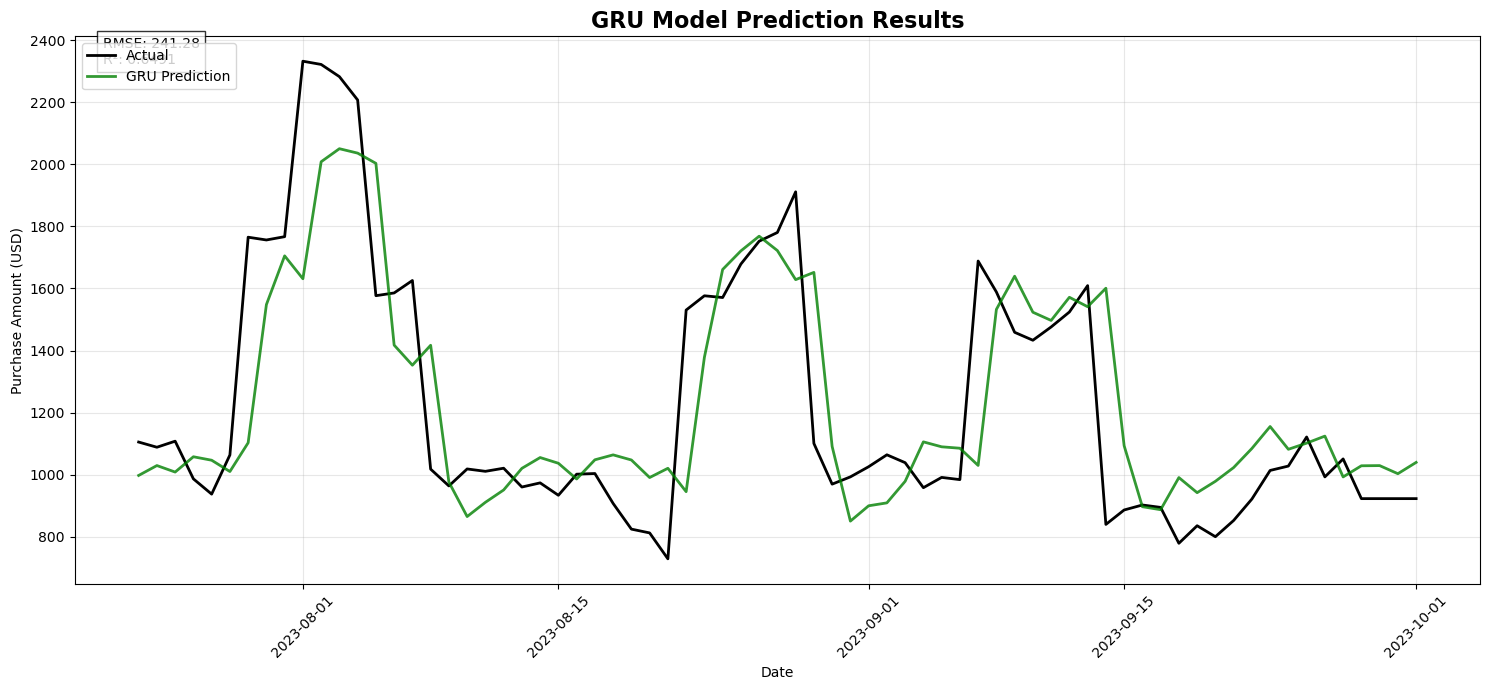

In [27]:
plt.figure(figsize=(15,7))
# Make sure to align test_data.index with y_test_inv length
aligned_test_dates = test_data.index[-len(y_test_inv):]
plt.plot(aligned_test_dates, y_test_inv,
         label='Actual', linewidth=2, color='black')
plt.plot(aligned_test_dates, y_pred_gru_inv,
         label='GRU Prediction', linewidth=2, color='green', alpha=0.8)
plt.title('GRU Model Prediction Results', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Purchase Amount (USD)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.text(0.02, 0.95, f'RMSE: {rmse_gru:.2f}\nR²: {r2_gru:.4f}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

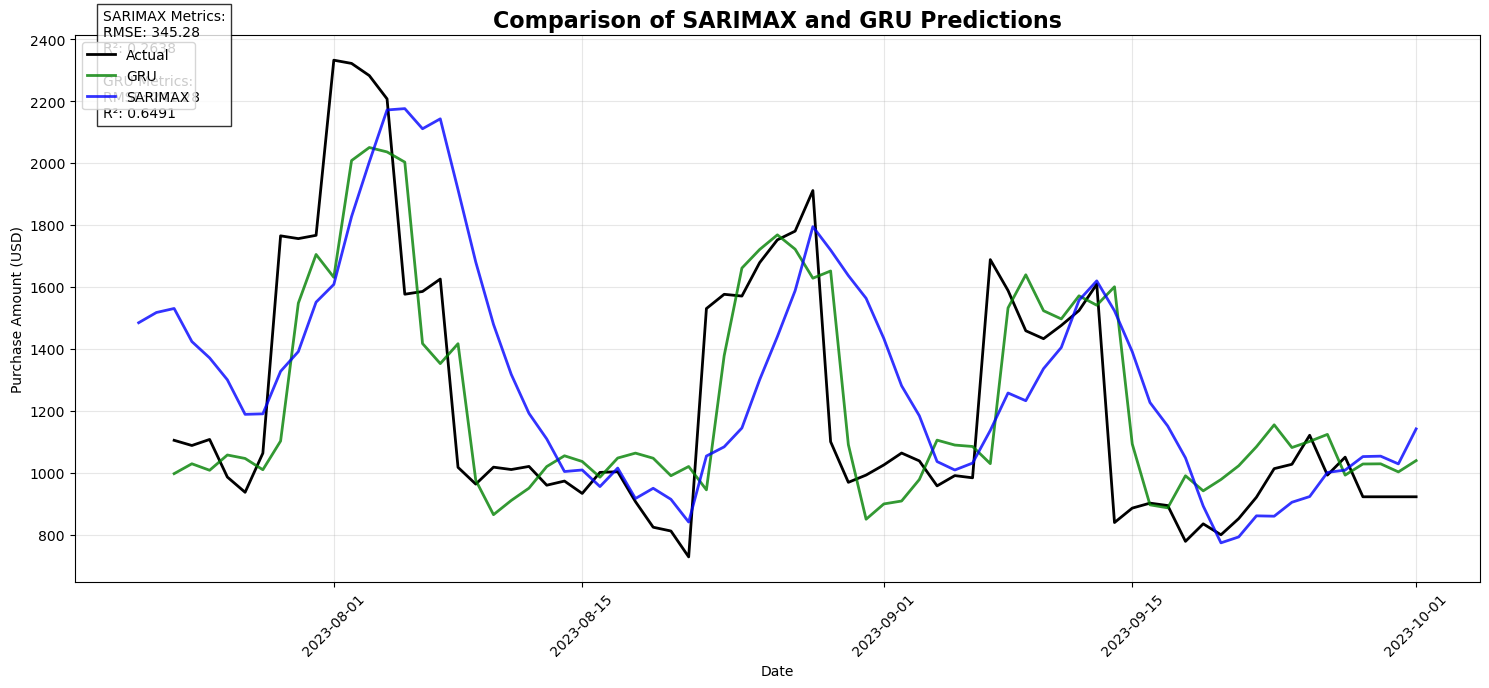

In [28]:
plt.figure(figsize=(15,7))
plt.plot(aligned_test_dates, y_test_inv, label='Actual', linewidth=2, color='black')
plt.plot(aligned_test_dates, y_pred_gru_inv, label='GRU', linewidth=2, color='green', alpha=0.8)
plt.plot(test_data.index, sarimax_pred, label='SARIMAX', linewidth=2, color='blue', alpha=0.8)
plt.title('Comparison of SARIMAX and GRU Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Purchase Amount (USD)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
text = f'SARIMAX Metrics:\nRMSE: {rmse_sarimax:.2f}\nR²: {r2_sarimax:.4f}\n\n'
text += f'GRU Metrics:\nRMSE: {rmse_gru:.2f}\nR²: {r2_gru:.4f}'
plt.text(0.02, 0.85, text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

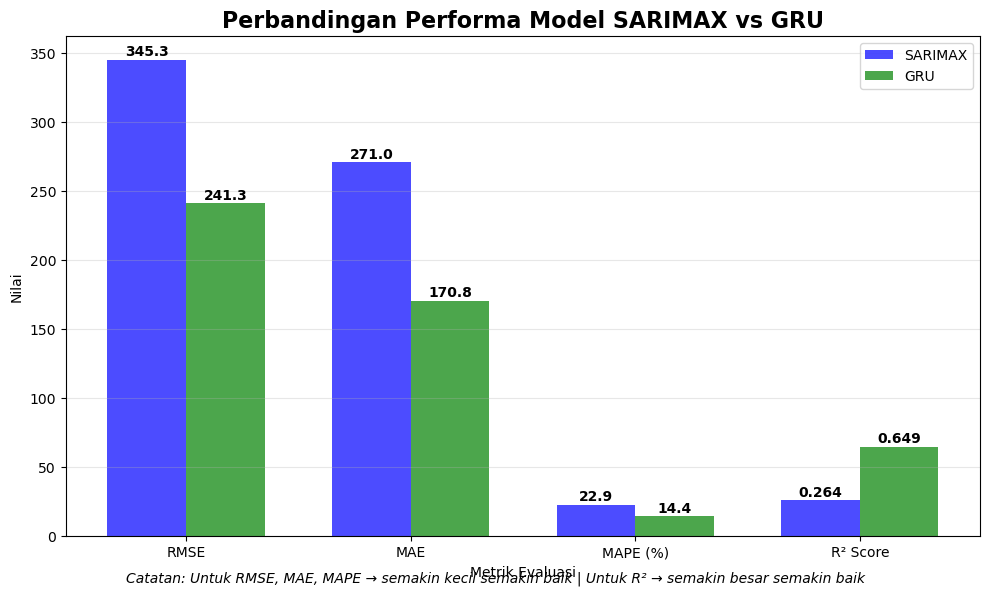

In [29]:
plt.figure(figsize=(10, 6))
metrics = ['RMSE', 'MAE', 'MAPE (%)', 'R² Score']
sarimax_values = [rmse_sarimax, mae_sarimax, mape_sarimax, r2_sarimax*100]
gru_values = [rmse_gru, mae_gru, mape_gru, r2_gru*100]
x = np.arange(len(metrics))
width = 0.35
bars1 = plt.bar(x - width/2, sarimax_values, width, label='SARIMAX', color='blue', alpha=0.7)
bars2 = plt.bar(x + width/2, gru_values, width, label='GRU', color='green', alpha=0.7)
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    if i == 3:
        plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
                 f'{sarimax_values[i]/100:.3f}', ha='center', va='bottom', fontweight='bold')
        plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
                 f'{gru_values[i]/100:.3f}', ha='center', va='bottom', fontweight='bold')
    else:
        plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.5,
                 f'{sarimax_values[i]:.1f}', ha='center', va='bottom', fontweight='bold')
        plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
                 f'{gru_values[i]:.1f}', ha='center', va='bottom', fontweight='bold')
plt.title('Perbandingan Performa Model SARIMAX vs GRU', fontsize=16, fontweight='bold')
plt.xlabel('Metrik Evaluasi')
plt.ylabel('Nilai')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.figtext(0.5, 0.02,
           'Catatan: Untuk RMSE, MAE, MAPE → semakin kecil semakin baik | Untuk R² → semakin besar semakin baik',
           ha='center', fontsize=10, style='italic')
plt.tight_layout()
plt.show()

## Evaluating

In [30]:
print(f"\n{'='*50}")
print("RINGKASAN PERFORMA:")
print(f"{'='*50}")
better_rmse = "SARIMAX" if rmse_sarimax < rmse_gru else "GRU"
better_r2 = "SARIMAX" if r2_sarimax > r2_gru else "GRU"
print(f"Model dengan RMSE terbaik: {better_rmse}")
print(f"Model dengan R² terbaik: {better_r2}")
print(f"Improvement SARIMAX: Using best params {best_params}")
print(f"{'='*50}")


RINGKASAN PERFORMA:
Model dengan RMSE terbaik: GRU
Model dengan R² terbaik: GRU
Improvement SARIMAX: Using best params ((2, 0, 2), (1, 1, 1, 7))


In [31]:
print("\nPrediksi 7 Hari Ke Depan:")
print("================================")
print("Tanggal            SARIMAX     GRU")
print("----------------------------------------")
for i in range(7):
    date = future_dates_gru[i].strftime('%Y-%m-%d')
    sarimax = future_pred_sarimax[i]
    gru = future_pred_inv_gru[i][0]
    print(f"{date}  {sarimax:9.2f}  {gru:9.2f}")


Prediksi 7 Hari Ke Depan:
Tanggal            SARIMAX     GRU
----------------------------------------
2023-10-02     821.29    1039.73
2023-10-03     994.17    1151.02
2023-10-04    1010.13    1242.55
2023-10-05    1069.29    1306.13
2023-10-06    1054.72    1341.73
2023-10-07    1007.85    1353.08
2023-10-08    1142.71    1345.65


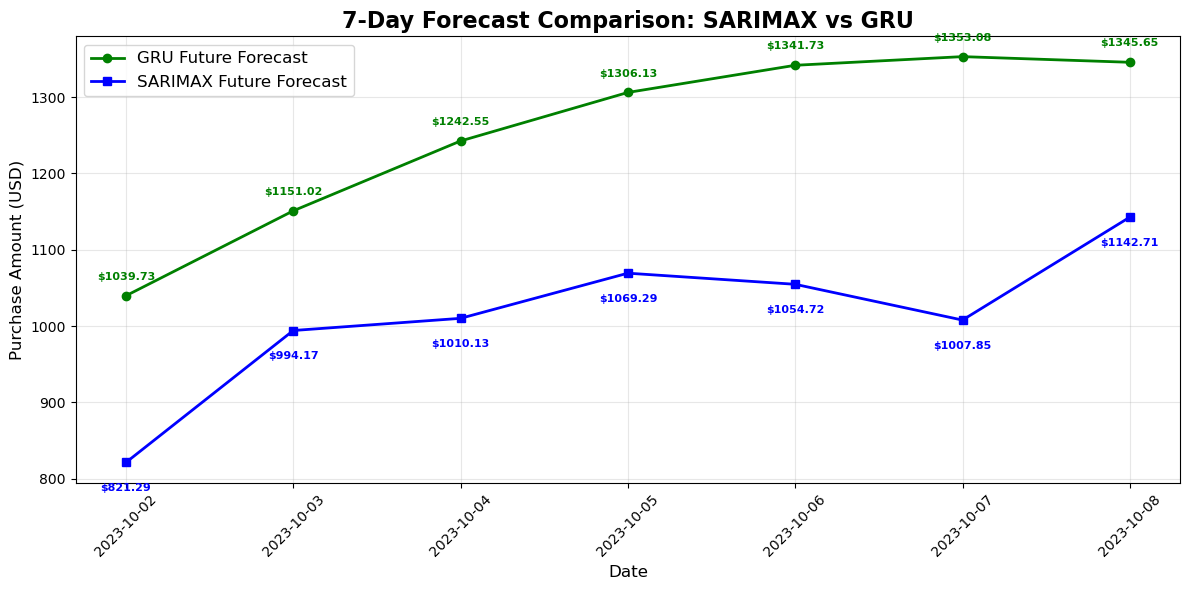

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(future_dates_gru, future_pred_inv_gru, 'o-', label='GRU Future Forecast', color='green', linewidth=2)
plt.plot(future_dates_sarimax, future_pred_sarimax, 's-', label='SARIMAX Future Forecast', color='blue', linewidth=2)
for i in range(len(future_dates_gru)):
    # GRU annotation
    plt.annotate(f"${future_pred_inv_gru[i][0]:.2f}",
                xy=(future_dates_gru[i], future_pred_inv_gru[i][0]),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=8, fontweight='bold', color='green')

    # SARIMAX annotation
    plt.annotate(f"${future_pred_sarimax[i]:.2f}",
                xy=(future_dates_sarimax[i], future_pred_sarimax[i]),
                xytext=(0, -15),
                textcoords="offset points",
                ha='center', va='top',
                fontsize=8, fontweight='bold', color='blue')

plt.title('7-Day Forecast Comparison: SARIMAX vs GRU', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Purchase Amount (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
print("\nPrediksi 73 Hari Terakhir:")
print("================================")
print("Tanggal            Actual      SARIMAX     GRU")
print("------------------------------------------------")
aligned_test_dates_73 = aligned_test_dates[-73:]
gru_pred_73 = y_pred_gru_inv[-73:]
gru_actual_73 = y_test_inv[-73:]
sarimax_pred_73 = []
for date in aligned_test_dates_73:
    if date in test_data.index:
        idx = test_data.index.get_loc(date)
        sarimax_pred_73.append(sarimax_pred[idx])
    else:
        sarimax_pred_73.append(np.nan)  # Handle missing dates

for i in range(len(aligned_test_dates_73)):
    date = aligned_test_dates_73[i].strftime('%Y-%m-%d')
    actual = gru_actual_73[i][0]
    sarimax = sarimax_pred_73[i] if i < len(sarimax_pred_73) else np.nan
    gru = gru_pred_73[i][0]
    print(f"{date}  {actual:9.2f}  {sarimax:9.2f}  {gru:9.2f}")

print(f"\nNote: Showing last 73 days of predictions")


Prediksi 73 Hari Terakhir:
Tanggal            Actual      SARIMAX     GRU
------------------------------------------------
2023-07-23    1105.29    1530.65     997.74
2023-07-24    1088.57    1423.84    1029.58
2023-07-25    1108.07    1371.12    1008.63
2023-07-26     986.71    1300.53    1057.92
2023-07-27     937.57    1189.10    1046.75
2023-07-28    1063.71    1190.70    1010.33
2023-07-29    1765.00    1327.82    1102.98
2023-07-30    1756.07    1391.53    1547.87
2023-07-31    1766.71    1551.02    1704.91
2023-08-01    2331.79    1608.28    1631.16
2023-08-02    2321.36    1827.21    2007.98
2023-08-03    2282.07    2003.48    2050.01
2023-08-04    2206.93    2171.18    2035.79
2023-08-05    1576.64    2175.51    2002.83
2023-08-06    1585.50    2110.56    1417.50
2023-08-07    1625.57    2142.57    1352.82
2023-08-08    1018.07    1913.89    1417.00
2023-08-09     963.93    1680.47     976.39
2023-08-10    1018.64    1479.31     865.36
2023-08-11    1011.00    1318.02     911